In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd

%matplotlib inline

Let's revisit Schrodinger's equation for the harmonic oscillator. The equation to solve is

$$-\frac{\hbar^2}{2m} \frac{d^2\psi}{dx^2} + \frac{1}{2}m\omega^2x^2\psi = E\psi.$$

We can rewrite to make the code more obvious:

$$\frac{d^2\psi}{dx^2} = -\frac{2m}{\hbar^2}\left(E - \frac{1}{2}m\omega^2x^2\right)\psi.$$

In [2]:
def qho(y, x, E, m=1.0, hbar=1.0, omega=1.0):
    """RHS for a quantum harmonic oscillator
    
    Parameters:
    -----------
    y : iterable of floats
        contains $\psi(x)$ and $\psi'(x)$
    x : float
        the position at which we're evaluating the equation
    E : float
        Energy of the quantum state
    m : float, optional
        mass; defaults to 1
    hbar : float, optional
           Planck's constant/2pi; defaults to 1
    omega : float, optional
            frequency of the oscillator; defaults to 1
    
    Returns:
    --------
    float : the right hand side of the time independent schrodinger
            equation for the harmonic oscillator:
            $$\frac{d^2\psi}{dx^2} = -\frac{2m}{\hbar^2}
            \left(E - \frac{1}{2}m\omega^2x^2\right)\psi.$$
    """
    psi, psiprime = y
    psidoubleprime = -(2*m/hbar**2)*(E-m*omega**2*x**2/2)*psi
    
    return np.array([psiprime, psidoubleprime])

Choosing initial conditions for this is difficult, because both $\psi$ and $\psi'$ go asymptotically to zero as $|x|$ gets large. Instead, we will integrate from the middle outward. This requires some knowlege of the physical system (symmetric potentials yield symmetric wave functions, for example) and isn't always possible. In this case, though, it works wonders.

In [3]:
def mirror_result(domain, result, even=True):
    """mirror a result across x=0
    
    This allows us to integrate from the center outward on the 
    positive side, and mirror the result on the negative side.
    
    Parameters:
    -----------
    domain : numpy array
             the domain of integration
    result : numpy array
             output from odeint
    even : boolean
           True if the result is an even function
           This could probably be refactored out if we check to see
           if the initial value/slope are consistent with even/odd
           functions.
           
    Returns:
    --------
    two numpy arrays with the extended domain and extended result.
    
    """
    negdom = -np.flip(domain, 0)
    if even:
        negres = np.flip(result, 0)
    else:
        negres = -np.flip(result, 0)
    fulldom = np.concatenate([negdom, domain])
    fullres = np.concatenate([negres, result])
    
    return fulldom, fullres

With that in hand, solving the equation is easy if we know the energies. We get non-normalized solutions, but that's okay -- we can apply normalization after the fact.

The half solution looks like this:

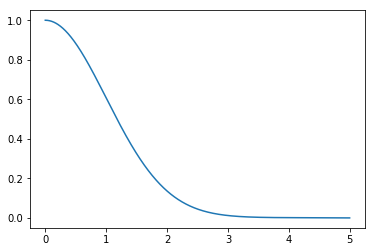

In [4]:
domain = np.linspace(0,5,1000)
y0 = (1.0, 0.0)
result = odeint(qho, y0, domain, args=(0.5,))
plt.plot(domain, result[:,0])

... and when mirrored, we get:

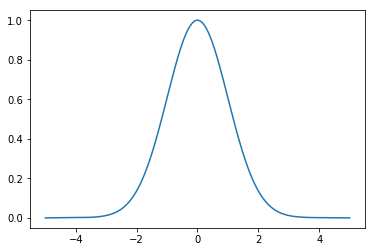

In [5]:
fulldom, fullres = mirror_result(domain, result)

plt.plot(fulldom, fullres[:,0])

Additional wave functions come from incrementing the energy.

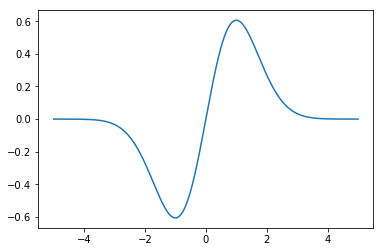

In [6]:
y0 = (0.0, 1.0)
result = odeint(qho, y0, domain, args=(1.5,))
fulldom, fullres = mirror_result(domain, result, even=False)
plt.plot(fulldom, fullres[:,0])

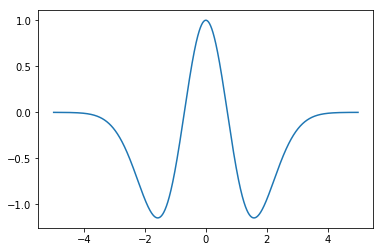

In [7]:
y0 = (1.0, 0.0)
result = odeint(qho, y0, domain, args=(2.5,))
fulldom, fullres = mirror_result(domain, result, even=True)
plt.plot(fulldom, fullres[:,0])

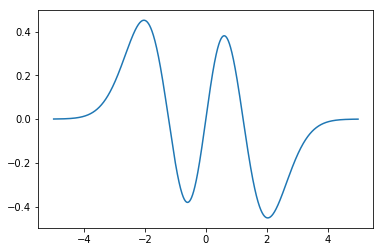

In [8]:
y0 = (0.0, 1.0)
result = odeint(qho, y0, domain, args=(3.5,))
fulldom, fullres = mirror_result(domain, result, even=False)
plt.plot(fulldom, fullres[:,0])

What if we don't know the energy? Let's try some guesses.

(0, 2)

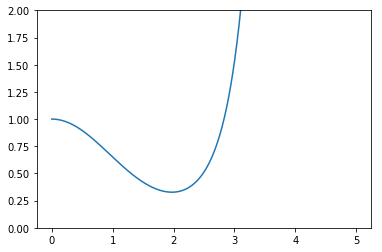

In [9]:
domain = np.linspace(0,5,1000)
y0 = (1.0, 0.0)
result = odeint(qho, y0, domain, args=(0.45,))
plt.plot(domain, result[:,0])
plt.ylim(0,2)

Guessing too low means the function doesn't get down to zero. Let's guess higher.

(-2, 2)

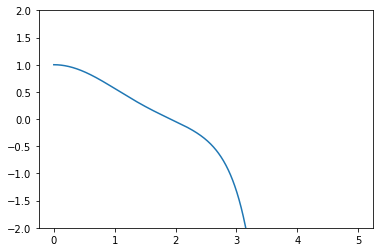

In [10]:
domain = np.linspace(0,5,1000)
y0 = (1.0, 0.0)
result = odeint(qho, y0, domain, args=(0.55,))
plt.plot(domain, result[:,0])
plt.ylim(-2,2)

Guessing too high means we cross zero and keep going.  We could keep guessing and checking by hand, but I'm going to get tired of that really quickly. As it happens, there is (more than one) automated way to take care of this problem: use a root finding function from the `scipy.optimize` library. [Documentation is here](https://docs.scipy.org/doc/scipy/reference/optimize.html).

We're working in one dimension (so we don't need to worry about the multidimensional methods) and assuming you can find a bracketing interval, the bisection method provided by `bisect` is both fast and stable. The other obvious choice is Newton-Raphson, but it can be unstable if you aren't careful.  For our purposes, the work of finding a bracketing interval isn't too bad, so we will use `bisect`.

In [11]:
from scipy.optimize import bisect

In [12]:
help(bisect)

Help on function bisect in module scipy.optimize.zeros:

bisect(f, a, b, args=(), xtol=2e-12, rtol=8.8817841970012523e-16, maxiter=100, full_output=False, disp=True)
    Find root of a function within an interval.
    
    Basic bisection routine to find a zero of the function `f` between the
    arguments `a` and `b`. `f(a)` and `f(b)` cannot have the same signs.
    Slow but sure.
    
    Parameters
    ----------
    f : function
        Python function returning a number.  `f` must be continuous, and
        f(a) and f(b) must have opposite signs.
    a : number
        One end of the bracketing interval [a,b].
    b : number
        The other end of the bracketing interval [a,b].
    xtol : number, optional
        The computed root ``x0`` will satisfy ``np.allclose(x, x0,
        atol=xtol, rtol=rtol)``, where ``x`` is the exact root. The
        parameter must be nonnegative.
    rtol : number, optional
        The computed root ``x0`` will satisfy ``np.allclose(x, x0,
        

We want to find the energy for which $\psi$ asymptotically approaches zero as $x$ gets large. Unfortunately, that is hard to do. Like physical shooting, as your target gets farther away, it's harder to hit, and "asymptotically approaches" is less amenable to calculation than "is equal to".

We address these two issues by not addressing them. That is, we choose a "large" value $x_\text{large}$, and say that $\psi(x_\text{large}) = 0$. This will introduce error into our result, but if we choose $x_\text{large}$ appropriately, that error will be small enough that we don't care about it.

In any case, we will want a convenient way to find the value of $\psi$ at the end of our integration interval.

In [13]:
def bc(E, even=True, endpoint=5):
    """Find the boundary value for a given energy.
    
    Parameters:
    -----------
    E : number
        The energy to test
    even : boolean, optional
           is the function even?
    endpoint : number, optional
               the endpoint for the integration interval.
    Returns:
    --------
    psi(endpoint) : number
             The value of psi at x=endpoint. 
    """
    domain = np.linspace(0,endpoint,1000)
    if even:
        y0 = (1.0, 0.0)
    else:
        y0 = (0.0, 1.0)
        
    result = odeint(qho, y0, domain, args=(E,))
    return result[-1, 0]

In [14]:
bc(0.65)

-5482.6625365161326

In [15]:
bc(0.45)

2665.0532400852826

In [16]:
bisect(bc, 0.45, 0.65)

0.49999997978011373

In [17]:
def find_energies(n=3):
    """Find the energies of the QHO.
    
    Parameters:
    -----------
    n : integer
        how many energies to find
        
    Returns:
    --------
    energies : list
               energy values
    """
    
    energies = []
    even = True
    bracket_found = False
    starting_value = 0.01
    e_step = 0.3
    
    # prime the pump
    prev_energy = starting_value
    prev_bc = bc(prev_energy)
    
    for idx in range(n):
        # try energies until we find two values that bracket an eigenvalue
        while not bracket_found:
            current_energy = prev_energy + e_step
            current_bc = bc(current_energy, even=even)
            if np.sign(current_bc) != np.sign(prev_bc):
                bracket_found = True
            else:
                prev_energy = current_energy
                prev_bc = current_bc
        # use bisect to get the actual value
        energies.append(bisect(bc, prev_energy, current_energy, args=(even, )))
        
        # set up for the next energy
        # function changes parity
        even = not len(energies) % 2
        # populate prev_energy
        prev_energy = current_energy
        # we no longer have a bracket
        bracket_found = False
        # recalculate bc with the new parity
        prev_bc = bc(prev_energy, even=even)
    return energies

In [18]:
find_energies(3)

[0.4999999797813506, 1.499999994033497, 2.5000001066485855]

In [19]:
find_energies(9)

[0.4999999797813506,
 1.499999994033497,
 2.5000001066485855,
 3.5000012164416696,
 4.5000126752527265,
 5.500098692229731,
 6.500602374840452,
 7.50292793226741,
 8.51147134079634]

## Refining things

Let's make our solution more modular.

In [20]:
def schro_rhs(y, x, E, V, m=1.0, hbar=1.0):
    """RHS for the time independent schrodinger equation.
    
    Parameters:
    -----------
    y : iterable of floats
        contains $\psi(x)$ and $\psi'(x)$
    x : float
        the position at which we're evaluating the equation
    E : float
        Energy of the quantum state
    V : function
        function for the potential
    m : float, optional
        mass; defaults to 1
    hbar : float, optional
           Planck's constant/2pi; defaults to 1
    
    Returns:
    --------
    float : the right hand side of the time independent schrodinger
            equation for the time independent Schrodinger equation:
            $$\frac{d^2\psi}{dx^2} = -\frac{2m}{\hbar^2}
            \left(E - V(x) \right)\psi.$$
    """
    psi, psiprime = y
    psidoubleprime = -(2*m/hbar**2)*(E-V(x))*psi
    
    return np.array([psiprime, psidoubleprime])

def bc(E, V, even=True, endpoint=5):
    """Find the boundary value for a given energy.
    
    Parameters:
    -----------
    E : number
        The energy to test
    V : function
        The potential function
    even : boolean, optional
           is the function even?
    endpoint : number, optional
               the endpoint for the integration interval.
    Returns:
    --------
    psi(endpoint) : number
             The value of psi at x=endpoint. 
    """
    domain = np.linspace(0,endpoint,1000)
    if even:
        y0 = (1.0, 0.0)
    else:
        y0 = (0.0, 1.0)
        
    result = odeint(schro_rhs, y0, domain, args=(E,V,))
    return result[-1, 0]

def find_energies(V, n=3):
    """Find the energies allowed by the TISE for a particular potential.
    
    Parameters:
    -----------
    V : function
        the potential
    n : integer, optional
        how many energies to find; defaults to 3
        
    Returns:
    --------
    energies : list
               energy values
    """
    
    if not callable(V):
        raise TypeError("{} is not callable".format(V))
    energies = []
    even = True
    bracket_found = False
    starting_value = 0.01
    e_step = 0.3
    
    # prime the pump
    prev_energy = starting_value
    prev_bc = bc(prev_energy, V)
    
    for idx in range(n):
        # try energies until we find two values that bracket an eigenvalue
        while not bracket_found:
            current_energy = prev_energy + e_step
            current_bc = bc(current_energy, V, even=even)
            if np.sign(current_bc) != np.sign(prev_bc):
                bracket_found = True
            else:
                prev_energy = current_energy
                prev_bc = current_bc
        # use bisect to get the actual value
        energies.append(bisect(bc, prev_energy, current_energy, args=(V, even, )))
        
        # set up for the next energy
        # function changes parity
        even = not len(energies) % 2
        # populate prev_energy
        prev_energy = current_energy
        # we no longer have a bracket
        bracket_found = False
        # recalculate bc with the new parity
        prev_bc = bc(prev_energy, V, even=even)
    return energies

In [21]:
find_energies(3)

TypeError: 3 is not callable

In [22]:
def harmonic(x, m=1, omega=1):
    """Potential for the harmonic oscillator"""
    
    return m*omega**2*x**2/2

In [23]:
find_energies(harmonic, 3)

[0.4999999797813506, 1.499999994033497, 2.5000001066485855]

## Plotting results

You did part of this for homework 8.

In [24]:
def plot_energy_diagram(V, n=3):
    """Plot an energy diagram for a potential well."""
    
    domain = np.linspace(-5, 5, 1000)
    halfdomain = np.linspace(0, 5, 500)
    potential = V(domain)
    minx = np.min(domain)
    maxx = np.max(domain)
    
    fig, ax = plt.subplots(1)
    fig.set_figwidth(10)
    fig.set_figheight(6)
    
    ax.plot(domain, potential)
    ax.set_axis_off()
    
    # plot energies and eigenfunctions
    energies = find_energies(V, n)
    even = True
    for energy in energies:
        ax.plot([minx, maxx], [energy, energy], ":", color="gray")
        if even:
            y0 = (1.0, 0)
        else:
            y0 = (0.0, 1.0)
        result = odeint(schro_rhs, y0, halfdomain, args=(energy, V))
        fulldom, fullres = mirror_result(halfdomain, result, even)
        eigenfunction = 0.3*(fullres[:,0]) + energy
        ax.plot(fulldom, eigenfunction)
        ax.text(4.5, energy,"$E={:5.2f}$".format(energy),  verticalalignment="bottom")
        even = not even
    deltae = energies[-1] - energies[-2]    
    ax.set_ylim(-0.1, energies[-1] + deltae)

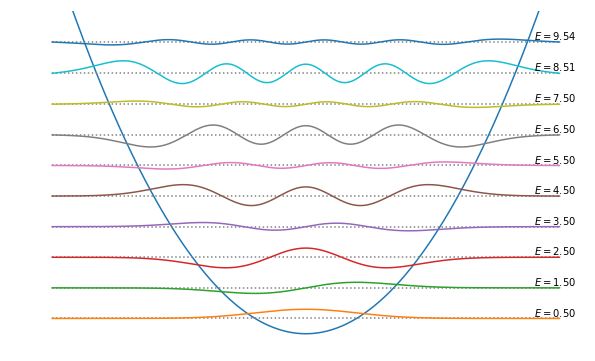

In [25]:
plot_energy_diagram(harmonic, n=10)

## adding an automated test

In [26]:
help(np.testing.assert_allclose)

Help on function assert_allclose in module numpy.testing.utils:

assert_allclose(actual, desired, rtol=1e-07, atol=0, equal_nan=True, err_msg='', verbose=True)
    Raises an AssertionError if two objects are not equal up to desired
    tolerance.
    
    The test is equivalent to ``allclose(actual, desired, rtol, atol)``.
    It compares the difference between `actual` and `desired` to
    ``atol + rtol * abs(desired)``.
    
    .. versionadded:: 1.5.0
    
    Parameters
    ----------
    actual : array_like
        Array obtained.
    desired : array_like
        Array desired.
    rtol : float, optional
        Relative tolerance.
    atol : float, optional
        Absolute tolerance.
    equal_nan : bool, optional.
        If True, NaNs will compare equal.
    err_msg : str, optional
        The error message to be printed in case of failure.
    verbose : bool, optional
        If True, the conflicting values are appended to the error message.
    
    Raises
    ------
    Ass

In [27]:
import numpy as np
from numpy.testing import assert_allclose

def test_find_energies_sho(n=3):
    """Test that find_energies gives correct results for the harmonic oscillator."""
    
    def sho_test(x):
        """Potential for the harmonic oscillator, with m=1, omega=1"""    
        return x**2/2

    desired_energies = np.array([i+0.5 for i in range(n)])
    assert_allclose(find_energies(sho_test, n), desired_energies)

In [28]:
test_find_energies_sho()

In [29]:
test_find_energies_sho(4)

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

(mismatch 25.0%)
 x: array([ 0.5     ,  1.5     ,  2.5     ,  3.500001])
 y: array([ 0.5,  1.5,  2.5,  3.5])

## Integrate end to end

In [30]:
def harmonic(x, m=1, omega=1):
    """Potential for the harmonic oscillator"""
    
    return m*omega**2*x**2/2

def schro_rhs(y, x, E, V, m=1.0, hbar=1.0):
    """RHS for the time independent schrodinger equation.
    
    Parameters:
    -----------
    y : iterable of floats
        contains $\psi(x)$ and $\psi'(x)$
    x : float
        the position at which we're evaluating the equation
    E : float
        Energy of the quantum state
    V : function
        function for the potential
    m : float, optional
        mass; defaults to 1
    hbar : float, optional
           Planck's constant/2pi; defaults to 1
    
    Returns:
    --------
    float : the right hand side of the time independent schrodinger
            equation for the time independent Schrodinger equation:
            $$\frac{d^2\psi}{dx^2} = -\frac{2m}{\hbar^2}
            \left(E - V(x) \right)\psi.$$
    """
    psi, psiprime = y
    psidoubleprime = -(2*m/hbar**2)*(E-V(x))*psi
    
    return np.array([psiprime, psidoubleprime])

def bc(E, V, endpoint=5):
    """Find the boundary value for a given energy.
    
    Parameters:
    -----------
    E : number
        The energy to test
    V : function
        The potential function
    endpoint : number, optional
               the endpoint for the integration interval.
    Returns:
    --------
    psi(endpoint) : number
             The value of psi at x=endpoint. 
    """
    domain = np.linspace(-endpoint,endpoint,1000)
    y0 = (0.0, 1.0)
        
    result = odeint(schro_rhs, y0, domain, args=(E,V,))
    return result[-1, 0]

def find_energies(V, n=3):
    """Find the energies allowed by the TISE for a particular potential.
    
    Parameters:
    -----------
    V : function
        the potential
    n : integer, optional
        how many energies to find; defaults to 3
        
    Returns:
    --------
    energies : list
               energy values
    """
    
    if not callable(V):
        raise TypeError("{} is not callable".format(V))
    energies = []
    bracket_found = False
    starting_value = 0.01
    e_step = 0.3
    
    # prime the pump
    prev_energy = starting_value
    prev_bc = bc(prev_energy, V)
    
    for idx in range(n):
        # try energies until we find two values that bracket an eigenvalue
        while not bracket_found:
            current_energy = prev_energy + e_step
            current_bc = bc(current_energy, V)
            if np.sign(current_bc) != np.sign(prev_bc):
                bracket_found = True
            else:
                prev_energy = current_energy
                prev_bc = current_bc
        # use bisect to get the actual value
        energies.append(bisect(bc, prev_energy, current_energy, args=(V,)))
        
        # set up for the next energy
        # populate prev_energy
        prev_energy = current_energy
        prev_bc = current_bc
        # we no longer have a bracket
        bracket_found = False
    return energies

In [31]:
test_find_energies_sho(3)

In [32]:
test_find_energies_sho(4)

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

(mismatch 25.0%)
 x: array([ 0.5     ,  1.5     ,  2.5     ,  3.500001])
 y: array([ 0.5,  1.5,  2.5,  3.5])

## Refactor to improve accuracy
Notice that the energies get worse with larger n.

In [33]:
test_find_energies_sho(10)

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

(mismatch 70.0%)
 x: array([ 0.5     ,  1.5     ,  2.5     ,  3.500001,  4.500013,  5.500099,
        6.500602,  7.502928,  8.511471,  9.536573])
 y: array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5])

In [34]:
def find_energies(V, n=3):
    """Find the energies allowed by the TISE for a particular potential.
    
    Parameters:
    -----------
    V : function
        the potential
    n : integer, optional
        how many energies to find; defaults to 3
        
    Returns:
    --------
    energies : list
               energy values
    """
    
    if not callable(V):
        raise TypeError("{} is not callable".format(V))
    energies = []
    bracket_found = False
    starting_value = 0.01
    e_step = 0.3
    
    # prime the pump
    prev_energy = starting_value
    endpoint = turning_point(V, prev_energy) + 8
    prev_bc = bc(prev_energy, V, endpoint)
    
    for idx in range(n):
        # try energies until we find two values that bracket an eigenvalue
        while not bracket_found:
            current_energy = prev_energy + e_step
            endpoint = turning_point(V, current_energy) + 8
            current_bc = bc(current_energy, V, endpoint)
            if np.sign(current_bc) != np.sign(prev_bc):
                bracket_found = True
            else:
                prev_energy = current_energy
                prev_bc = current_bc
        # use bisect to get the actual value
        energies.append(bisect(bc, prev_energy, current_energy, args=(V,endpoint,)))
        
        # set up for the next energy
        # populate prev_energy
        prev_energy = current_energy
        prev_bc = current_bc
        # we no longer have a bracket
        bracket_found = False
    return energies

def turning_point(V, E):
    """find the classical turning point for the potential and energy"""
    
    # this works for SHO; won't for other potentials
    A = V(1)
    return np.sqrt(E/A)

In [35]:
test_find_energies_sho(10)

In [36]:
find_energies(harmonic, 10)

[0.5000000045123304,
 1.50000000277556,
 2.4999999969919005,
 3.5000000024103066,
 4.499999994199386,
 5.500000014679028,
 6.500000005429097,
 7.500000009179853,
 8.500000006631089,
 9.500000021197557]

In [37]:
find_energies(harmonic, 10)

[0.5000000045123304,
 1.50000000277556,
 2.4999999969919005,
 3.5000000024103066,
 4.499999994199386,
 5.500000014679028,
 6.500000005429097,
 7.500000009179853,
 8.500000006631089,
 9.500000021197557]

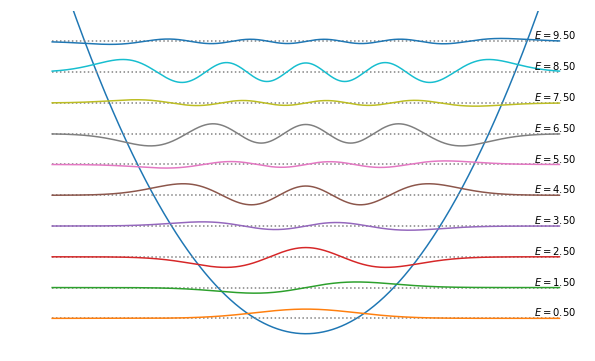

In [38]:
plot_energy_diagram(harmonic, 10)

## Make a python package

In [48]:
import shooting

## Vectorized potentials

In [54]:
def finite_double_if(x, a=1, V0=1):
    if x < -a:
        return 0
    elif x <= a:
        return -V0
    else:
        return 0

def finite_square_well(x, a=1, V0=1):
    if np.abs(x) <= a:
        return -V0
    else:
        return 0


In [53]:
finite_double_if(1.01)

0

In [55]:
domain = np.linspace(-5, 5, 1000)
V = finite_square_well(domain)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [56]:
help(np.vectorize)

Help on class vectorize in module numpy.lib.function_base:

class vectorize(builtins.object)
 |  vectorize(pyfunc, otypes=None, doc=None, excluded=None, cache=False,
 |            signature=None)
 |  
 |  Generalized function class.
 |  
 |  Define a vectorized function which takes a nested sequence of objects or
 |  numpy arrays as inputs and returns an single or tuple of numpy array as
 |  output. The vectorized function evaluates `pyfunc` over successive tuples
 |  of the input arrays like the python map function, except it uses the
 |  broadcasting rules of numpy.
 |  
 |  The data type of the output of `vectorized` is determined by calling
 |  the function with the first element of the input.  This can be avoided
 |  by specifying the `otypes` argument.
 |  
 |  Parameters
 |  ----------
 |  pyfunc : callable
 |      A python function or method.
 |  otypes : str or list of dtypes, optional
 |      The output data type. It must be specified as either a string of
 |      typecode ch

In [58]:
fsw_vectorized = np.vectorize(finite_square_well)

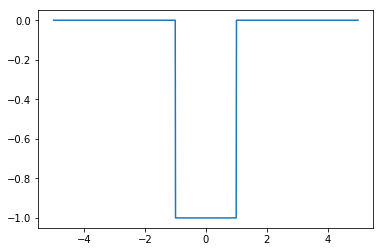

In [60]:
plt.plot(domain, fsw_vectorized(domain))